# Resistance Mapping

## Table of Contents

1. [Compute Resistance Values](#1.-Compute-Resistance-Values)
2. [Apply Resistance Values to the Land Cover Raster](#2.-Apply-Resistance-Values-to-the-Land-Cover-Raster)
3. [Focal Nodes](#3.-Focal-Nodes)
4. [Running Circuitscape](#4.-Running-Circuitscape)
5. [Generate Hexagonal Grid Resistance Rasters](##.-Generate-Hexagonal-Grid-Resistance-Rasters)
6. 

## **1. Compute Resistance Values**
**Objective:** Convert the land cover raster into resistance values using two different scaling techniques.

In [1]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Load the EUNIS Reclassification Table

In [3]:
# Load the CSV file
eunis_file = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/mavi_data.csv"
df = pd.read_csv(eunis_file)

# Display column names and first few rows
print("Column Names:", df.columns)
print(df.head())  # View first rows

# Check data types of each column
print(df.dtypes)


Column Names: Index(['EUNIS_CODE', 'EUNIS_DESC', 'Suitability Value (1 - 10)', 'Unnamed: 3',
       'Unnamed: 4'],
      dtype='object')
  EUNIS_CODE                                    EUNIS_DESC  \
0        NaN                                           NaN   
1          C                                         Water   
2         D1                       Raised and blanket bogs   
3         D2  Valley mires, poor fens and transition mires   
4         D4    Base-rich fens and calcareous spring mires   

  Suitability Value (1 - 10)       Unnamed: 3              Unnamed: 4  
0                  Bufo bufo  Rana temporaria  Lissotriton helveticus  
1                         10               10                      10  
2                         10               10                      10  
3                         10               10                      10  
4                         10               10                      10  
EUNIS_CODE                    object
EUNIS_DESC           

### Identify Problematic Species Columns

In [4]:
df = pd.read_csv(eunis_file, skiprows=1)  # Skip the extra header row

# Rename columns properly
df.columns = ["EUNIS_Code", "EUNIS_Description", "Bufo_bufo_Suitability", 
              "Rana_temporaria_Suitability", "Lissotriton_helveticus_Suitability"]

# Drop rows with NaN values that came from the skipped header row
df = df.dropna()

# Check cleaned data
print(df.head())


  EUNIS_Code                             EUNIS_Description  \
0          C                                         Water   
1         D1                       Raised and blanket bogs   
2         D2  Valley mires, poor fens and transition mires   
3         D4    Base-rich fens and calcareous spring mires   
4         E1                                Dry grasslands   

   Bufo_bufo_Suitability  Rana_temporaria_Suitability  \
0                   10.0                         10.0   
1                   10.0                         10.0   
2                   10.0                         10.0   
3                   10.0                         10.0   
4                    7.0                          5.0   

   Lissotriton_helveticus_Suitability  
0                                10.0  
1                                10.0  
2                                10.0  
3                                10.0  
4                                 5.0  


In [5]:
# Convert numeric columns to float
cols_to_convert = ["Bufo_bufo_Suitability", "Rana_temporaria_Suitability", "Lissotriton_helveticus_Suitability"]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors="coerce")

# Check for NaN values after conversion
print("NaN values detected:\n", df.isna().sum())

# Drop or replace NaN values
df = df.dropna()  # Removes rows with non-numeric suitability values


NaN values detected:
 EUNIS_Code                            0
EUNIS_Description                     0
Bufo_bufo_Suitability                 0
Rana_temporaria_Suitability           0
Lissotriton_helveticus_Suitability    0
dtype: int64


### Compute Resistance Values for Each Species

In [9]:
# Compute resistance values for each species individually
df["Inverse_Bufo"] = 11 - df["Bufo_bufo_Suitability"]
df["Inverse_Rana"] = 11 - df["Rana_temporaria_Suitability"]
df["Inverse_Lissotriton"] = 11 - df["Lissotriton_helveticus_Suitability"]

df["Logarithmic_Bufo"] = 10 ** (11 - df["Bufo_bufo_Suitability"])
df["Logarithmic_Rana"] = 10 ** (11 - df["Rana_temporaria_Suitability"])
df["Logarithmic_Lissotriton"] = 10 ** (11 - df["Lissotriton_helveticus_Suitability"])

# Normalize the Logarithmic Scaling (keep range 1-1000)
for species in ["Bufo", "Rana", "Lissotriton"]:
    max_value = df[f"Logarithmic_{species}"].max()
    df[f"Logarithmic_{species}"] = (df[f"Logarithmic_{species}"] / max_value) * 1000

# Display updated table
from IPython.display import display
display(df)


,EUNIS_Code,EUNIS_Description,Bufo_bufo_Suitability,Rana_temporaria_Suitability,Lissotriton_helveticus_Suitability,Inverse_Scaling,Logarithmic_Scaling,Inverse_Bufo,Inverse_Rana,Inverse_Lissotriton,Logarithmic_Bufo,Logarithmic_Rana,Logarithmic_Lissotriton
0,C,Water,10.0,10.0,10.0,1.000000,0.000001,1.0,1.0,1.0,0.000001,0.000001,0.000001
1,D1,Raised and blanket bogs,10.0,10.0,10.0,1.000000,0.000001,1.0,1.0,1.0,0.000001,0.000001,0.000001
2,D2,"Valley mires, poor fens and transition mires",10.0,10.0,10.0,1.000000,0.000001,1.0,1.0,1.0,0.000001,0.000001,0.000001
3,D4,Base-rich fens and calcareous spring mires,10.0,10.0,10.0,1.000000,0.000001,1.0,1.0,1.0,0.000001,0.000001,0.000001
4,E1,Dry grasslands,7.0,5.0,5.0,5.333333,0.021544,4.0,6.0,6.0,0.001000,0.100000,0.100000
5,E2,Mesic grasslands,7.0,6.0,6.0,4.666667,0.004642,4.0,5.0,5.0,0.001000,0.010000,0.010000
6,E3,Seasonally wet and wet grasslands,8.0,8.0,7.0,3.333333,0.000215,3.0,3.0,4.0,0.000100,0.000100,0.001000
7,E4,Alpine and subalpine grasslands,6.0,9.0,5.0,4.333333,0.002154,5.0,2.0,6.0,0.010000,0.000010,0.100000
8,E5,Woodland fringes and clearings and tall forb s...,6.0,8.0,8.0,3.666667,0.000464,5.0,3.0,3.0,0.010000,0.000100,0.000100
9,F2,"Arctic, alpine and subalpine scrub",4.0,8.0,4.0,5.666667,0.046416,7.0,3.0,7.0,1.000000,0.000100,1.000000


## **2. Apply Resistance Values to the Land Cover Raster**

### Load and Check the Land Cover Raster

In [13]:
import rasterio

# Path to your raster file
landcover_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/LandCover.tif"

# Open the raster and check metadata
with rasterio.open(landcover_raster_path) as src:
    print("Raster Metadata:", src.meta)
    print("NoData Value:", src.nodata)

    # Read the first band
    landcover_data = src.read(1)
    
    # Check unique values in the raster
    unique_values = set(landcover_data.flatten())
    print("Unique Raster Values:", unique_values)


Raster Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': 32767.0, 'width': 6369, 'height': 5971, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(30.0, 0.0, 195953.21484855085,
       0.0, -30.0, 734068.8661739801)}
NoData Value: 32767.0
Unique Raster Values: {-32768, 1, 2, 3, 0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 4, 32767}


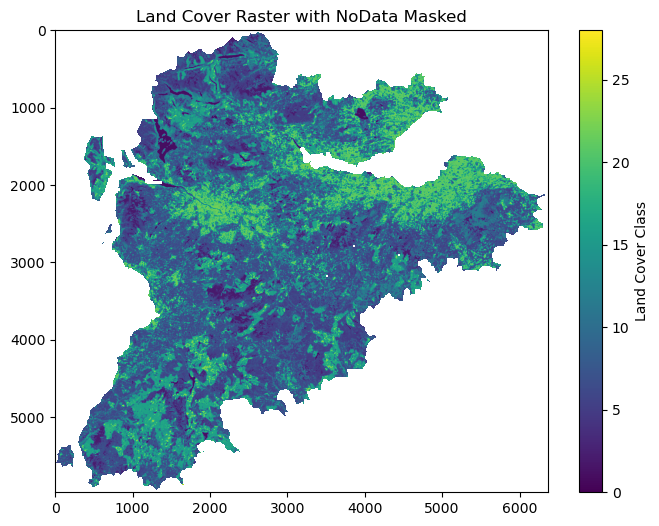

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Path to the land cover raster
landcover_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/LandCover.tif"

# Open the raster
with rasterio.open(landcover_raster_path) as src:
    landcover_data = src.read(1)  # Read raster data
    nodata_value = src.nodata  # Get NoData value (32767.0)

# Mask both 32767 (NoData) and -32768 (potential errors)
landcover_masked = np.ma.masked_where((landcover_data == nodata_value) | (landcover_data == -32768), landcover_data)

# Plot with properly masked NoData values
plt.figure(figsize=(8, 6))
plt.imshow(landcover_masked, cmap="viridis")
plt.title("Land Cover Raster with NoData Masked")
plt.colorbar(label="Land Cover Class")
plt.show()


In [17]:
# Count occurrences of '0' in the raster
zero_count = np.sum(landcover_data == 0)
print(f"Number of pixels with value 0: {zero_count}")


Number of pixels with value 0: 8


### Address Multiple No Data Values

In [18]:
# Define the corrected NoData value (choosing -32768 as new NoData)
NEW_NODATA_VALUE = -32768

# Update metadata to store correct NoData
with rasterio.open(landcover_raster_path) as src:
    meta = src.meta.copy()
    meta.update(nodata=NEW_NODATA_VALUE)  # Change NoData in metadata

    # Load raster again
    landcover_data = src.read(1)

    # Replace old NoData values (32767, 0) with new NoData (-32768)
    landcover_data[landcover_data == src.nodata] = NEW_NODATA_VALUE
    landcover_data[landcover_data == 0] = NEW_NODATA_VALUE

# Save corrected raster
fixed_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/LandCover_Fixed.tif"
with rasterio.open(fixed_raster_path, "w", **meta) as dst:
    dst.write(landcover_data.astype(rasterio.int16), 1)

print(f"✅ Fixed raster saved at: {fixed_raster_path}")


✅ Fixed raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/LandCover_Fixed.tif


In [19]:
# Open the fixed raster
with rasterio.open(fixed_raster_path) as src:
    print("Updated Raster NoData Value:", src.nodata)

    # Check if -32768 is correctly set as NoData
    unique_values = set(src.read(1).flatten())
    print("Unique Raster Values (after fixing):", unique_values)


Updated Raster NoData Value: -32768.0
Unique Raster Values (after fixing): {-32768, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}


Raster NoData Value: -32768.0


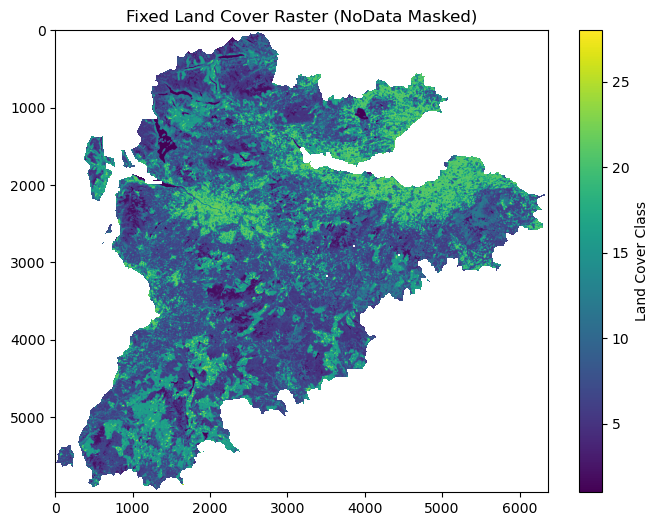

In [21]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to the fixed land cover raster
fixed_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/LandCover_Fixed.tif"

# Open the raster and check metadata
with rasterio.open(fixed_raster_path) as src:
    landcover_data = src.read(1)  # Read raster data
    nodata_value = src.nodata  # Get NoData value from metadata

    print(f"Raster NoData Value: {nodata_value}")

# Mask NoData values before plotting
landcover_masked = np.ma.masked_where(landcover_data == nodata_value, landcover_data)

# Plot the masked raster
plt.figure(figsize=(8, 6))
plt.imshow(landcover_masked, cmap="viridis")
plt.title("Fixed Land Cover Raster (NoData Masked)")
plt.colorbar(label="Land Cover Class")
plt.show()



### Map Raster Values to Computed Resistance

In [22]:
# Identify unique land cover values in the raster
unique_values = np.unique(landcover_data)
print("Unique Land Cover Classes in the Raster:", unique_values)


Unique Land Cover Classes in the Raster: [-32768      1      2      3      4      5      6      7      8      9
     10     11     12     13     14     16     17     18     19     20
     21     22     23     24     25     26     27     28]


In [26]:
import pandas as pd

# Path to the reference table
reference_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/reference.csv"

# Load the reference table
df_reference = pd.read_csv(reference_path)

# Display first few rows
print(df_reference.head())

# Create mappings from VALUE (1-28) to EUNIS Codes and Descriptions
raster_to_eunis = dict(zip(df_reference["VALUE"], df_reference["EUNIS_CODE"]))
raster_to_desc = dict(zip(df_reference["VALUE"], df_reference["EUNIS_DESC"]))

# Print mapping verification
print("Raster to EUNIS Mapping:", raster_to_eunis)
print("Raster to Description Mapping:", raster_to_desc)


   OID_  VALUE    COUNT EUNIS_CODE  \
0     0      1   726628          C   
1     1      2  2114649         D1   
2     2      3   172023         D2   
3     3      4        2         D4   
4     4      5  4475765         E1   

                                     EUNIS_DESC  \
0                                         Water   
1                       Raised and blanket bogs   
2  Valley mires, poor fens and transition mires   
3    Base-rich fens and calcareous spring mires   
4                                Dry grasslands   

                                         LEGEND_TXT  
0                                          C: Water  
1                       D1: Raised and blanket bogs  
2  D2: Valley mires, poor fens and transition mires  
3    D4: Base-rich fens and calcareous spring mires  
4                                E1: Dry grasslands  
Raster to EUNIS Mapping: {1: 'C', 2: 'D1', 3: 'D2', 4: 'D4', 5: 'E1', 6: 'E2', 7: 'E3', 8: 'E4', 9: 'E5', 10: 'F2', 11: 'F3', 12: 'F4', 13: 

In [28]:
import pandas as pd

# Load the reference table (VALUE to EUNIS mapping)
reference_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/reference.csv"
df_reference = pd.read_csv(reference_path)

# Load the EUNIS resistance table
eunis_file = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/mavi_data.csv"
df_reclass = pd.read_csv(eunis_file, skiprows=1)  # Skip extra header row

# Rename columns properly
df_reclass.columns = ["EUNIS_Code", "EUNIS_Description", "Bufo_bufo_Suitability", 
                      "Rana_temporaria_Suitability", "Lissotriton_helveticus_Suitability"]

# Convert suitability values to numeric
cols_to_convert = ["Bufo_bufo_Suitability", "Rana_temporaria_Suitability", "Lissotriton_helveticus_Suitability"]
df_reclass[cols_to_convert] = df_reclass[cols_to_convert].apply(pd.to_numeric, errors="coerce")

# Compute resistance values for each species
df_reclass["Inverse_Bufo"] = 11 - df_reclass["Bufo_bufo_Suitability"]
df_reclass["Inverse_Rana"] = 11 - df_reclass["Rana_temporaria_Suitability"]
df_reclass["Inverse_Lissotriton"] = 11 - df_reclass["Lissotriton_helveticus_Suitability"]

df_reclass["Logarithmic_Bufo"] = 10 ** (11 - df_reclass["Bufo_bufo_Suitability"])
df_reclass["Logarithmic_Rana"] = 10 ** (11 - df_reclass["Rana_temporaria_Suitability"])
df_reclass["Logarithmic_Lissotriton"] = 10 ** (11 - df_reclass["Lissotriton_helveticus_Suitability"])

# Normalize Logarithmic Scaling (range 1-1000)
for species in ["Bufo", "Rana", "Lissotriton"]:
    max_value = df_reclass[f"Logarithmic_{species}"].max()
    df_reclass[f"Logarithmic_{species}"] = (df_reclass[f"Logarithmic_{species}"] / max_value) * 1000

# Create mapping dictionaries from EUNIS codes to resistance values
eunis_to_inverse_bufo = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Inverse_Bufo"]))
eunis_to_inverse_rana = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Inverse_Rana"]))
eunis_to_inverse_lissotriton = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Inverse_Lissotriton"]))

eunis_to_log_bufo = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Logarithmic_Bufo"]))
eunis_to_log_rana = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Logarithmic_Rana"]))
eunis_to_log_lissotriton = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Logarithmic_Lissotriton"]))

# Map VALUE (1-28) to EUNIS Codes using the reference table
value_to_eunis = dict(zip(df_reference["VALUE"], df_reference["EUNIS_CODE"]))

# Map VALUE (1-28) directly to computed resistance values
value_to_inverse_bufo = {val: eunis_to_inverse_bufo.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_inverse_rana = {val: eunis_to_inverse_rana.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_inverse_lissotriton = {val: eunis_to_inverse_lissotriton.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}

value_to_log_bufo = {val: eunis_to_log_bufo.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_log_rana = {val: eunis_to_log_rana.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_log_lissotriton = {val: eunis_to_log_lissotriton.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}

# Display mapping verification
print("VALUE to Inverse Resistance Mapping (Bufo bufo):", value_to_inverse_bufo)
print("VALUE to Logarithmic Resistance Mapping (Bufo bufo):", value_to_log_bufo)


VALUE to Inverse Resistance Mapping (Bufo bufo): {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 4.0, 6: 4.0, 7: 3.0, 8: 5.0, 9: 5.0, 10: 7.0, 11: 1.0, 12: 1.0, 13: 3.0, 14: 4.0, 16: 5.0, 17: 3.0, 18: 2.0, 19: 7.0, 20: 9.0, 21: 8.0, 22: 9.0, 23: 8.0, 24: 3.0, 25: 7.0, 26: 7.0, 27: 10.0, 28: 10.0, -32768: nan, 0: nan}
VALUE to Logarithmic Resistance Mapping (Bufo bufo): {1: 1.0000000000000002e-06, 2: 1.0000000000000002e-06, 3: 1.0000000000000002e-06, 4: 1.0000000000000002e-06, 5: 0.001, 6: 0.001, 7: 9.999999999999999e-05, 8: 0.01, 9: 0.01, 10: 1.0, 11: 1.0000000000000002e-06, 12: 1.0000000000000002e-06, 13: 9.999999999999999e-05, 14: 0.001, 16: 0.01, 17: 9.999999999999999e-05, 18: 1e-05, 19: 1.0, 20: 100.0, 21: 10.0, 22: 100.0, 23: 10.0, 24: 9.999999999999999e-05, 25: 1.0, 26: 1.0, 27: 1000.0, 28: 1000.0, -32768: nan, 0: nan}


In [29]:
# Recompute inverse resistance for validation
df_reclass["Recomputed_Inverse_Bufo"] = 11 - df_reclass["Bufo_bufo_Suitability"]

# Compare with previous mapping
for val, eunis in value_to_eunis.items():
    expected = df_reclass[df_reclass["EUNIS_Code"] == eunis]["Recomputed_Inverse_Bufo"].values[0]
    actual = value_to_inverse_bufo[val]
    if expected != actual:
        print(f"Mismatch for Raster Value {val}: Expected {expected}, Got {actual}")


Mismatch for Raster Value -32768: Expected nan, Got nan
Mismatch for Raster Value 0: Expected nan, Got nan


In [30]:
# Recompute logarithmic resistance for validation
df_reclass["Recomputed_Log_Bufo"] = 10 ** (11 - df_reclass["Bufo_bufo_Suitability"])

# Normalize again
max_log = df_reclass["Recomputed_Log_Bufo"].max()
df_reclass["Recomputed_Log_Bufo"] = (df_reclass["Recomputed_Log_Bufo"] / max_log) * 1000

# Compare with previous mapping
for val, eunis in value_to_eunis.items():
    expected = df_reclass[df_reclass["EUNIS_Code"] == eunis]["Recomputed_Log_Bufo"].values[0]
    actual = value_to_log_bufo[val]
    if expected != actual:
        print(f"Mismatch for Raster Value {val}: Expected {expected}, Got {actual}")


Mismatch for Raster Value -32768: Expected nan, Got nan
Mismatch for Raster Value 0: Expected nan, Got nan


### Apply the Mapping to the Raster

In [31]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to the fixed land cover raster
fixed_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/LandCover_Fixed.tif"

# Open the raster
with rasterio.open(fixed_raster_path) as src:
    landcover_data = src.read(1)  # Read raster data
    meta = src.meta  # Get metadata

# Create empty arrays for resistance rasters
resistance_inv_bufo = np.copy(landcover_data)
resistance_inv_rana = np.copy(landcover_data)
resistance_inv_lissotriton = np.copy(landcover_data)

resistance_log_bufo = np.copy(landcover_data)
resistance_log_rana = np.copy(landcover_data)
resistance_log_lissotriton = np.copy(landcover_data)

# Convert raster values to resistance values using the mappings
for val in np.unique(landcover_data):
    if val in value_to_inverse_bufo:
        resistance_inv_bufo[landcover_data == val] = value_to_inverse_bufo[val]
        resistance_inv_rana[landcover_data == val] = value_to_inverse_rana[val]
        resistance_inv_lissotriton[landcover_data == val] = value_to_inverse_lissotriton[val]

        resistance_log_bufo[landcover_data == val] = value_to_log_bufo[val]
        resistance_log_rana[landcover_data == val] = value_to_log_rana[val]
        resistance_log_lissotriton[landcover_data == val] = value_to_log_lissotriton[val]

# Mask NoData values before visualization
resistance_masked_bufo = np.ma.masked_where(landcover_data == -32768, resistance_inv_bufo)

# Plot the resistance raster for Bufo bufo (Inverse Scaling)
plt.figure(figsize=(8, 6))
plt.imshow(resistance_masked_bufo, cmap="coolwarm")
plt.title("Resistance Raster for Bufo bufo (Inverse Scaling)")
plt.colorbar(label="Resistance Value")
plt.show()


ValueError: cannot convert float NaN to integer

In [33]:
# Print unique raster values
print("Unique Land Cover Values in Raster:", np.unique(landcover_data))

# Print values that do not have corresponding resistance values
missing_values = [val for val in np.unique(landcover_data) if val not in value_to_inverse_bufo]
print("Missing Values (No Mapping Found):", missing_values)


Unique Land Cover Values in Raster: [-32768      1      2      3      4      5      6      7      8      9
     10     11     12     13     14     16     17     18     19     20
     21     22     23     24     25     26     27     28]
Missing Values (No Mapping Found): []


In [34]:
# Check for NaN values in the mapping
import numpy as np

nan_values = {val: resistance for val, resistance in value_to_inverse_bufo.items() if np.isnan(resistance)}
print("Land Cover Values with NaN Resistance:", nan_values)


Land Cover Values with NaN Resistance: {-32768: nan, 0: nan}


In [35]:
# Convert raster values to resistance values using the corrected mappings
for val in np.unique(landcover_data):
    if val in [-32768, 0]:  # Skip NoData and 0 values
        continue

    resistance_inv_bufo[landcover_data == val] = value_to_inverse_bufo[val]
    resistance_inv_rana[landcover_data == val] = value_to_inverse_rana[val]
    resistance_inv_lissotriton[landcover_data == val] = value_to_inverse_lissotriton[val]

    resistance_log_bufo[landcover_data == val] = value_to_log_bufo[val]
    resistance_log_rana[landcover_data == val] = value_to_log_rana[val]
    resistance_log_lissotriton[landcover_data == val] = value_to_log_lissotriton[val]

print("✅ Successfully applied resistance values while skipping NoData (-32768) and zero values.")


✅ Successfully applied resistance values while skipping NoData (-32768) and zero values.


In [36]:
# Output paths for the resistance rasters
output_inv_bufo = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo.tif"
output_inv_rana = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Rana.tif"
output_inv_lissotriton = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Lissotriton.tif"

output_log_bufo = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo.tif"
output_log_rana = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana.tif"
output_log_lissotriton = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Lissotriton.tif"

# Update metadata for new rasters
meta.update(dtype=rasterio.float32)

# Save the resistance rasters
for path, data in zip([output_inv_bufo, output_inv_rana, output_inv_lissotriton, 
                       output_log_bufo, output_log_rana, output_log_lissotriton], 
                      [resistance_inv_bufo, resistance_inv_rana, resistance_inv_lissotriton,
                       resistance_log_bufo, resistance_log_rana, resistance_log_lissotriton]):
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(data.astype(np.float32), 1)

print("✅ Resistance rasters saved successfully.")


✅ Resistance rasters saved successfully.


### Load and Check the Grid Structure

Since the resistance rasters are already in a square grid format, we simply verify that they align properly.

Grid Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 6369, 'height': 5971, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(30.0, 0.0, 195953.21484855085,
       0.0, -30.0, 734068.8661739801)}
NoData Value from Metadata: -32768.0


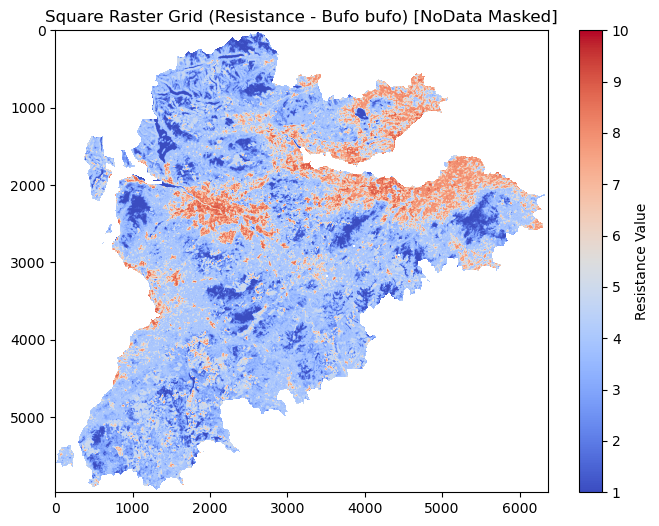

In [38]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load one of the resistance rasters (they all share the same grid)
resistance_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo.tif"

# Open the raster
with rasterio.open(resistance_raster_path) as src:
    landcover_data = src.read(1)  # Read raster data
    nodata_value = src.nodata  # Extract NoData value from metadata
    meta = src.meta  # Get metadata

# Print metadata (to confirm NoData handling)
print("Grid Metadata:", meta)
print("NoData Value from Metadata:", nodata_value)

# Mask NoData values explicitly
landcover_masked = np.ma.masked_where(landcover_data == nodata_value, landcover_data)

# Plot the masked raster
plt.figure(figsize=(8, 6))
plt.imshow(landcover_masked, cmap="coolwarm")
plt.title("Square Raster Grid (Resistance - Bufo bufo) [NoData Masked]")
plt.colorbar(label="Resistance Value")
plt.show()


### Convert Resistance Rasters to Correct Format

In [87]:
import os
import rasterio
import numpy as np

# Define input and output directories
resistance_raster_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Resistance"
corrected_raster_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance"

# Ensure the corrected resistance folder exists
os.makedirs(corrected_raster_dir, exist_ok=True)

# List of resistance rasters to correct
resistance_rasters = {
    "Inv_Bufo": os.path.join(resistance_raster_dir, "Resistance_Inv_Bufo.tif"),
    "Inv_Rana": os.path.join(resistance_raster_dir, "Resistance_Inv_Rana.tif"),
    "Inv_Lissotriton": os.path.join(resistance_raster_dir, "Resistance_Inv_Lissotriton.tif"),
    "Log_Bufo": os.path.join(resistance_raster_dir, "Resistance_Log_Bufo.tif"),
    "Log_Rana": os.path.join(resistance_raster_dir, "Resistance_Log_Rana.tif"),
    "Log_Lissotriton": os.path.join(resistance_raster_dir, "Resistance_Log_Lissotriton.tif")
}

# Process each resistance raster
for name, raster_path in resistance_rasters.items():
    corrected_tif_path = os.path.join(corrected_raster_dir, f"{name}_Corrected.tif")
    corrected_asc_path = os.path.join(corrected_raster_dir, f"{name}_Corrected.asc")

    # Open the original raster
    with rasterio.open(raster_path) as src:
        meta = src.meta.copy()
        resistance_data = src.read(1)  # Read raster data

        # Ensure values are integers
        resistance_data = resistance_data.astype(np.int32)

        # Maintain correct NoData value
        nodata_value = -32768
        resistance_data[resistance_data == src.nodata] = nodata_value

        # Update metadata
        meta.update(dtype=rasterio.int32, nodata=nodata_value)

    # Save corrected raster as GeoTIFF
    with rasterio.open(corrected_tif_path, "w", **meta) as dst:
        dst.write(resistance_data, 1)

    print(f"✅ Corrected Resistance Raster saved at: {corrected_tif_path}")

    # Create a new metadata dictionary for ASCII Grid (remove driver key)
    asc_meta = meta.copy()
    asc_meta.pop("driver", None)  # Remove existing driver to avoid conflict

    # Convert to Arc/Info ASCII Grid format
    with rasterio.open(corrected_asc_path, "w", driver="AAIGrid", **asc_meta) as dst:
        dst.write(resistance_data, 1)

    print(f"✅ ASCII Grid Format saved at: {corrected_asc_path}")

print("\n✅ All resistance rasters successfully converted and saved in the 'Corrected_Resistance' folder.")


✅ Corrected Resistance Raster saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\Inv_Bufo_Corrected.tif
✅ ASCII Grid Format saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\Inv_Bufo_Corrected.asc
✅ Corrected Resistance Raster saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\Inv_Rana_Corrected.tif
✅ ASCII Grid Format saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\Inv_Rana_Corrected.asc
✅ Corrected Resistance Raster saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\Inv_Lissotriton_Corrected.tif
✅ ASCII Grid Format saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\Inv_Lissotriton_Corrected.asc
✅ Corrected Resistance Raster saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\Log_Bufo_Corrected.tif
✅ ASCII Grid Format saved at: C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance\L

In [100]:
import rasterio
from rasterio.enums import Resampling

# File paths
input_raster = r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Inv_Bufo_Corrected.asc"
output_raster = r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Inv_Bufo_Resampled_60m.asc"

# Set new resolution (e.g., 60m)
new_resolution = 60  # Change to 90 if needed

# Open the original raster
with rasterio.open(input_raster) as src:
    # Calculate new dimensions
    new_width = int(src.width * (src.res[0] / new_resolution))
    new_height = int(src.height * (src.res[1] / new_resolution))

    # Resample raster
    data = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.average  # Average resampling for resistance values
    )

    # Update metadata
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    meta = src.meta.copy()
    meta.update({
        "height": new_height,
        "width": new_width,
        "transform": transform
    })

    # Save resampled raster
    with rasterio.open(output_raster, "w", **meta) as dst:
        dst.write(data)

print(f"✅ Resampled resistance raster saved at: {output_raster}")


✅ Resampled resistance raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Inv_Bufo_Resampled_60m.asc


## **3. Focal Nodes**

Focal nodes are **key locations** in connectivity modelling that act as **origins or destinations for species movement**. In this study, **SuDS ponds** are used as focal nodes for modelling amphibian connectivity in Central Scotland.

These SuDS locations come from **Rae et al. (2019)**, which evaluated **78 SuDS ponds across Scotland** and assessed their ecological role in supporting aquatic biodiversity, including amphibians.

### Source of Focal Nodes: Rae et al. (2019)
Rae et al. (2019) assessed **SuDS ponds in urban and peri-urban environments** and their **potential as biodiversity refuges**. Their study showed that:

✔ **SuDS can provide critical breeding and foraging habitats** for amphibians.  
✔ **Connectivity and surrounding land use significantly influence pond biodiversity**.  
✔ **Ponds near other wetlands and green infrastructure have higher amphibian species richness**.  

Since SuDS **act as stepping stones between habitats**, they are **ideal focal nodes** for modelling amphibian movement.

### Justification for Using SuDS as Focal Nodes
Using SuDS ponds as focal nodes in **Circuitscape connectivity modelling** is supported by several factors:

1.  **Ecological Relevance**  
   → SuDS ponds have been shown to **support amphibian populations** and act as movement corridors.  

2.  **Data Availability**  
   → The dataset from Rae et al. (2019) provides **spatially explicit SuDS locations**, allowing for a realistic representation of potential habitat patches.

3.  **Urban Fragmentation Context**  
   → Amphibian movement is **highly sensitive to landscape barriers** (e.g., roads, urban areas). SuDS connectivity modelling can help **identify key corridors and barriers**.

4.  **Practical Conservation Application**  
   → Understanding which SuDS ponds are **most critical for connectivity** can help guide **urban biodiversity planning**.

### Data Processing: Rasterizing the Focal Nodes
To integrate SuDS locations into **Circuitscape**, they need to be **converted from vector points (shapefile) to raster format**:

In [75]:
import rasterio
import geopandas as gpd
from rasterio.features import rasterize

# File paths
focal_nodes_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\focalnodes.shp"
reference_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Resistance\Resistance_Inv_Bufo.tif"
output_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster.tif"

# Load focal nodes shapefile
gdf_focal_nodes = gpd.read_file(focal_nodes_path)

# Remove invalid geometries
gdf_focal_nodes = gdf_focal_nodes[gdf_focal_nodes.geometry.notnull() & gdf_focal_nodes.geometry.is_valid]

# Load reference raster to extract metadata
with rasterio.open(reference_raster_path) as src:
    meta = src.meta.copy()
    transform = src.transform
    width, height = src.width, src.height
    crs = src.crs

# Ensure focal nodes are in the same CRS as the raster
if gdf_focal_nodes.crs != crs:
    gdf_focal_nodes = gdf_focal_nodes.to_crs(crs)

# Assign unique IDs to focal nodes
gdf_focal_nodes["ID"] = range(1, len(gdf_focal_nodes) + 1)

# Convert focal nodes to raster with unique IDs
shapes = [(geom, id) for geom, id in zip(gdf_focal_nodes.geometry, gdf_focal_nodes["ID"])]
focal_nodes_raster = rasterize(shapes, out_shape=(height, width), transform=transform, fill=255, dtype="uint8")

# Update metadata for saving
meta.update(dtype=rasterio.uint8, count=1, compress="lzw", nodata=255)

# Save rasterized focal nodes
with rasterio.open(output_raster_path, "w", **meta) as dst:
    dst.write(focal_nodes_raster, 1)

print(f"✅ Focal nodes raster with unique IDs saved at: {output_raster_path}")


✅ Focal nodes raster with unique IDs saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster.tif


In [77]:
import rasterio

# File path
focal_nodes_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster.tif"

# Open raster and print metadata
with rasterio.open(focal_nodes_raster_path) as src:
    raster_meta = src.meta  # Get raster metadata
    raster_bounds = src.bounds  # Get raster spatial extent
    raster_crs = src.crs  # Get coordinate reference system
    raster_nodata = src.nodata  # Get NoData value
    raster_shape = src.shape  # Get raster dimensions (height, width)
    raster_res = src.res  # Get pixel resolution
    unique_values = list(set(src.read(1).flatten()))  # Get unique values in raster

# Display raster metadata
print("\n✅ **Raster Metadata:**")
print(f"- **Driver:** {raster_meta['driver']}")
print(f"- **Width:** {raster_meta['width']} pixels")
print(f"- **Height:** {raster_meta['height']} pixels")
print(f"- **Number of Bands:** {raster_meta['count']}")
print(f"- **Data Type:** {raster_meta['dtype']}")
print(f"- **CRS:** {raster_crs}")
print(f"- **NoData Value:** {raster_nodata}")
print(f"- **Bounds:** {raster_bounds}")
print(f"- **Resolution (Pixel Size):** {raster_res}")
print(f"- **Unique Values in Raster:** {unique_values}")



✅ **Raster Metadata:**
- **Driver:** GTiff
- **Width:** 6369 pixels
- **Height:** 5971 pixels
- **Number of Bands:** 1
- **Data Type:** uint8
- **CRS:** EPSG:27700
- **NoData Value:** 255.0
- **Bounds:** BoundingBox(left=195953.21484855085, bottom=554938.8661739801, right=387023.21484855085, top=734068.8661739801)
- **Resolution (Pixel Size):** (30.0, 30.0)
- **Unique Values in Raster:** [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 255]


In [78]:
import rasterio

# File path to a resistance raster
resistance_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Resistance\Resistance_Inv_Bufo.tif"

# Open raster and print NoData value
with rasterio.open(resistance_raster_path) as src:
    resistance_nodata = src.nodata  # Get NoData value

print(f"✅ NoData Value in Resistance Raster: {resistance_nodata}")


✅ NoData Value in Resistance Raster: -32768.0


In [79]:
import rasterio
import numpy as np

# File paths
focal_nodes_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster.tif"
output_fixed_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Fixed.tif"

# Open focal nodes raster and update NoData value
with rasterio.open(focal_nodes_raster_path) as src:
    meta = src.meta.copy()
    focal_nodes_data = src.read(1)  # Read raster data
    
    # Replace current NoData value (255) with -32768
    focal_nodes_data = np.where(focal_nodes_data == 255, -32768, focal_nodes_data)
    
    # Update metadata with the correct NoData value
    meta.update(nodata=-32768, dtype=rasterio.int16)  # Change dtype to support -32768

# Save the updated raster
with rasterio.open(output_fixed_raster_path, "w", **meta) as dst:
    dst.write(focal_nodes_data, 1)

print(f"✅ Focal Nodes Raster Updated: NoData set to -32768 at {output_fixed_raster_path}")


✅ Focal Nodes Raster Updated: NoData set to -32768 at C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Fixed.tif


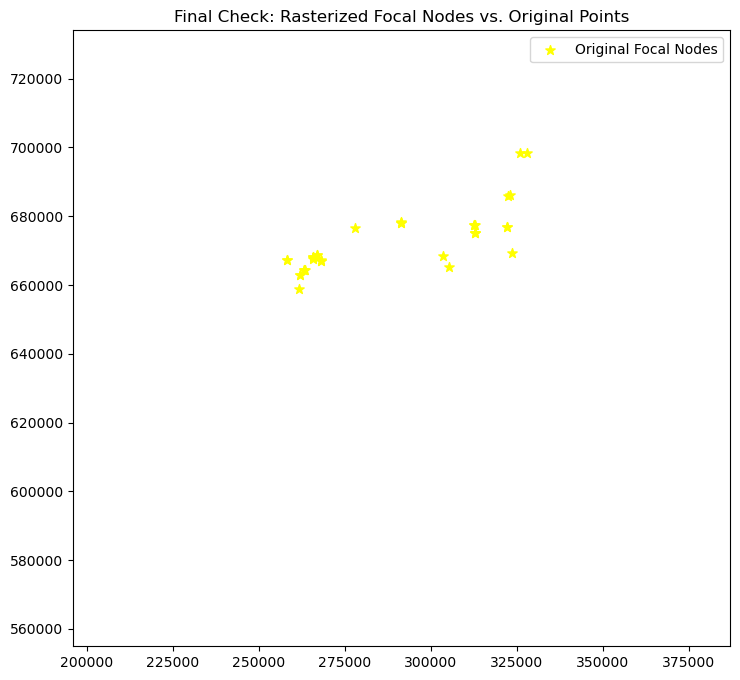


✅ **Final Focal Nodes Raster Metadata:**
- **CRS:** EPSG:27700
- **NoData Value:** -32768.0
- **Transform:** | 30.00, 0.00, 195953.21|
| 0.00,-30.00, 734068.87|
| 0.00, 0.00, 1.00|
- **Unique Values in Raster:** [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 --]


In [80]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.plot
import numpy as np

# File paths
focal_nodes_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Fixed.tif"
focal_nodes_shp_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\focalnodes.shp"

# Load raster
with rasterio.open(focal_nodes_raster_path) as src:
    focal_nodes_raster = src.read(1)  # Read raster data
    transform = src.transform  # Get transform metadata
    crs_raster = src.crs  # Get CRS of raster
    nodata_value = src.nodata  # Get NoData value

# Load vector focal nodes
gdf_focal_nodes = gpd.read_file(focal_nodes_shp_path)

# Ensure CRS alignment
if gdf_focal_nodes.crs != crs_raster:
    gdf_focal_nodes = gdf_focal_nodes.to_crs(crs_raster)

# Mask NoData values for better visualization
focal_nodes_raster = np.ma.masked_where(focal_nodes_raster == nodata_value, focal_nodes_raster)

# Plot raster and vector focal nodes
fig, ax = plt.subplots(figsize=(10, 8))
rasterio.plot.show(focal_nodes_raster, transform=transform, ax=ax, cmap="coolwarm")

# Overlay original vector focal nodes
gdf_focal_nodes.plot(ax=ax, color="yellow", markersize=50, marker="*", label="Original Focal Nodes")

plt.legend()
plt.title("Final Check: Rasterized Focal Nodes vs. Original Points")
plt.show()

# Print metadata to confirm correctness
print("\n✅ **Final Focal Nodes Raster Metadata:**")
print(f"- **CRS:** {crs_raster}")
print(f"- **NoData Value:** {nodata_value}")
print(f"- **Transform:** {transform}")
print(f"- **Unique Values in Raster:** {np.unique(focal_nodes_raster)}")


### Convert to Correct Format

In [93]:
import os
import rasterio
import numpy as np

# Define input and output paths
focal_nodes_tif = rfocal_nodes_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Fixed.tif"
focal_nodes_asc = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Final.asc"

# Open the focal nodes raster
with rasterio.open(focal_nodes_tif) as src:
    meta = src.meta.copy()
    focal_nodes_data = src.read(1)  # Read raster band

    # Ensure values are integers
    focal_nodes_data = focal_nodes_data.astype(np.int32)

    # Maintain correct NoData value (-32768)
    focal_nodes_data[focal_nodes_data == src.nodata] = -32768

    # Update metadata (remove driver key for ASCII conversion)
    meta.update(dtype=rasterio.int32, nodata=-32768)
    meta.pop("driver", None)

# Convert to Arc/Info ASCII Grid format
with rasterio.open(focal_nodes_asc, "w", driver="AAIGrid", **meta) as dst:
    dst.write(focal_nodes_data, 1)

print(f"✅ Focal Nodes Raster successfully converted to ASCII Grid: {focal_nodes_asc}")


✅ Focal Nodes Raster successfully converted to ASCII Grid: C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Final.asc


In [94]:
import os
import rasterio

# File path to the focal nodes raster
focal_nodes_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Final.asc"

# Check if the file exists
if os.path.exists(focal_nodes_raster_path):
    print(f"✅ The focal nodes raster exists: {focal_nodes_raster_path}")
else:
    print(f"❌ The focal nodes raster is missing. Check if it was created correctly.")

# Try opening it with Rasterio
try:
    with rasterio.open(focal_nodes_raster_path) as src:
        print("✅ Focal Nodes Raster successfully opened! Metadata:")
        print(src.meta)
except Exception as e:
    print(f"❌ Raster could not be opened: {e}")


✅ The focal nodes raster exists: C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Final.asc
✅ Focal Nodes Raster successfully opened! Metadata:
{'driver': 'AAIGrid', 'dtype': 'int32', 'nodata': -32768.0, 'width': 6369, 'height': 5971, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(30.0, 0.0, 195953.21484855085,
       0.0, -30.0, 734068.8661739801)}


In [95]:
import rasterio
import numpy as np

# File path to focal nodes raster
focal_nodes_asc = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Final.asc"

# Open raster and check unique values
with rasterio.open(focal_nodes_asc) as src:
    focal_nodes_data = src.read(1)  # Read raster data
    unique_values = np.unique(focal_nodes_data)  # Get unique values

print(f"✅ Unique Values in Focal Nodes Raster: {unique_values}")


✅ Unique Values in Focal Nodes Raster: [-32768      1      2      3      4      5      6      7      8      9
     10     11     12     13     14     15     16     17     18     19
     20     21     22     23     24     25     26     27     28     29
     30     31     32     33     34     35     36]


In [101]:
import rasterio
from rasterio.enums import Resampling

# File paths
input_focal_nodes = r"C:/GIS_Course/MScThesis-MaviSantarelli/data/Resistance/Focal_Nodes_Raster_Final.asc"
output_focal_nodes_resampled = r"C:/GIS_Course/MScThesis-MaviSantarelli/data/Resistance/Focal_Nodes_Resampled_60m.asc"

# Set new resolution (same as resistance raster)
new_resolution = 60  # Change to 90 if needed

# Open original focal nodes raster
with rasterio.open(input_focal_nodes) as src:
    # Calculate new dimensions
    new_width = int(src.width * (src.res[0] / new_resolution))
    new_height = int(src.height * (src.res[1] / new_resolution))

    # Resample raster
    data = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.nearest  # Nearest neighbor to keep focal node IDs
    )

    # Update metadata
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    meta = src.meta.copy()
    meta.update({
        "height": new_height,
        "width": new_width,
        "transform": transform
    })

    # Save resampled raster
    with rasterio.open(output_focal_nodes_resampled, "w", **meta) as dst:
        dst.write(data)

print(f"✅ Resampled focal nodes raster saved at: {output_focal_nodes_resampled}")


✅ Resampled focal nodes raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/data/Resistance/Focal_Nodes_Resampled_60m.asc


In [102]:
import rasterio
import numpy as np

focal_nodes_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Resistance/Focal_Nodes_Resampled_60m.asc"

with rasterio.open(focal_nodes_path) as src:
    focal_data = src.read(1)
    unique_values = np.unique(focal_data)

print(f"✅ Unique Values in Focal Nodes Raster: {unique_values}")


✅ Unique Values in Focal Nodes Raster: [-32768      4      6     19     23     32]


## **4. Running Circuitscape**

Now that the focal nodes raster and resistance raster are correctly formatted, the next step is to **run Circuitscape** to model amphibian connectivity across the study area.

Circuitscape is a **graph-based connectivity tool** that models species movement by treating the landscape as an **electrical circuit**, where:
- **Low-resistance areas** act as **conductive pathways** for movement.  
- **High-resistance areas** act as **barriers** to connectivity.  

In this phase, we will:
1. **Prepare the Circuitscape configuration file** (`.ini` file).  
2. **Run Circuitscape using the correct input rasters**.  
3. **Analyze the connectivity results** to identify important corridors and barriers.


### Prepare the Circuitscape Configuration File
Circuitscape requires a configuration file that defines:
- The **resistance raster** (landscape permeability).  
- The **focal nodes raster** (habitat patches or SuDS ponds).  
- The **mode of connectivity analysis** (`pairwise`, `all-to-one`, or `one-to-all`).  

For this study, **pairwise mode** is used to evaluate connectivity between all focal nodes.





In [89]:
import os

# Define paths
corrected_raster_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Corrected_Resistance"
config_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\resistance"

# Ensure the configuration file directory exists
os.makedirs(config_dir, exist_ok=True)

# Define the focal nodes raster (should remain in `.tif` format)
focal_nodes_raster = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Resistance\Focal_Nodes_Raster_Final.tif"

# List of corrected resistance rasters in `.asc` format
corrected_resistance_rasters = {
    "Inv_Bufo": os.path.join(corrected_raster_dir, "Inv_Bufo_Corrected.asc"),
    "Inv_Rana": os.path.join(corrected_raster_dir, "Inv_Rana_Corrected.asc"),
    "Inv_Lissotriton": os.path.join(corrected_raster_dir, "Inv_Lissotriton_Corrected.asc"),
    "Log_Bufo": os.path.join(corrected_raster_dir, "Log_Bufo_Corrected.asc"),
    "Log_Rana": os.path.join(corrected_raster_dir, "Log_Rana_Corrected.asc"),
    "Log_Lissotriton": os.path.join(corrected_raster_dir, "Log_Lissotriton_Corrected.asc")
}

# Generate Circuitscape configuration files
for species, resistance_raster in corrected_resistance_rasters.items():
    output_connectivity = os.path.join(
        r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Connectivity",
        f"{species}_Results.asc"
    )
    config_file_path = os.path.join(config_dir, f"circuitscape_config_{species}.ini")

    # Create Circuitscape config file content
    config_content = f"""
    [Circuitscape]
    data_type = raster
    habitat_file = {resistance_raster}
    focal_nodes = {focal_nodes_raster}
    output_file = {output_connectivity}
    mode = pairwise
    """

    # Save the configuration file
    with open(config_file_path, "w") as f:
        f.write(config_content)

    print(f"✅ Circuitscape configuration file saved at: {config_file_path}")


✅ Circuitscape configuration file saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\resistance\circuitscape_config_Inv_Bufo.ini
✅ Circuitscape configuration file saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\resistance\circuitscape_config_Inv_Rana.ini
✅ Circuitscape configuration file saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\resistance\circuitscape_config_Inv_Lissotriton.ini
✅ Circuitscape configuration file saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\resistance\circuitscape_config_Log_Bufo.ini
✅ Circuitscape configuration file saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\resistance\circuitscape_config_Log_Rana.ini
✅ Circuitscape configuration file saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\resistance\circuitscape_config_Log_Lissotriton.ini


In [91]:
import os

# Define the expected output directory
output_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Connectivity"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

print(f"✅ Output directory verified: {output_dir}")


✅ Output directory verified: C:\GIS_Course\MScThesis-MaviSantarelli\results\Connectivity


### Run Circuitscape
Once the configuration file is created, Circuitscape can be run in **Julia**, using:

```julia
using Circuitscape

config_file = "C:/GIS_Course/MScThesis-MaviSantarelli/results/circuitscape_config_{species}.ini"
compute(config_file)

In [108]:
import os

output_file = r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Connectivity/Inv_Bufo_Results.asc_cum_curmap.asc"

if os.path.exists(output_file):
    print(f"✅ The file exists: {output_file}")
else:
    print(f"❌ ERROR: The file does NOT exist.")


✅ The file exists: C:/GIS_Course/MScThesis-MaviSantarelli/results/Connectivity/Inv_Bufo_Results.asc_cum_curmap.asc


In [109]:
import rasterio
import numpy as np

output_file = r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Connectivity/Inv_Bufo_Results.asc_cum_curmap.asc"

with rasterio.open(output_file) as src:
    meta = src.meta
    data = src.read(1)  # Read raster values
    unique_values = np.unique(data)

print("✅ Raster Metadata:", meta)
print("✅ Unique Values in Raster:", unique_values)


✅ Raster Metadata: {'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3184, 'height': 2985, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(60.009422110553, 0.0, 195953.21484855085,
       0.0, -60.010050251256, 734068.8661739792)}
✅ Unique Values in Raster: [-9.999000e+03  0.000000e+00  1.381549e-09 ...  4.005382e+00  4.008084e+00
  4.015984e+00]


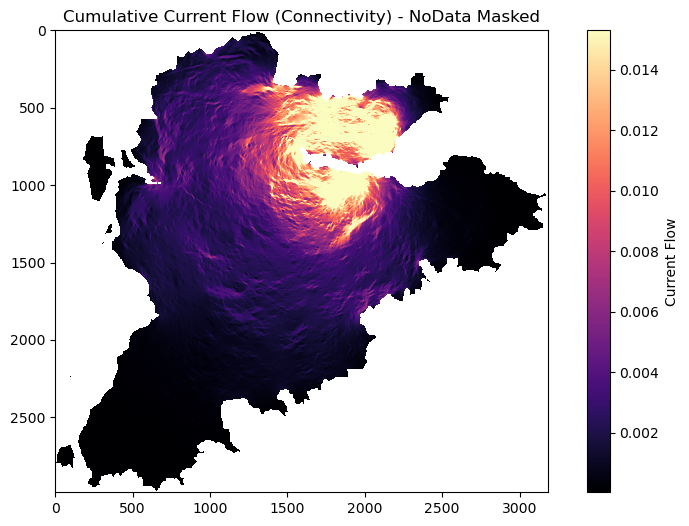

In [111]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define the output file path
output_file = r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Connectivity/Inv_Bufo_Results.asc_cum_curmap.asc"

# Open the raster file
with rasterio.open(output_file) as src:
    data = src.read(1)  # Read raster values

    # Mask NoData values (-9999)
    data_masked = np.ma.masked_where(data == -9999, data)

    # Plot the raster with NoData values masked
    plt.figure(figsize=(10, 6))
    plt.imshow(data_masked, cmap="magma", vmin=np.percentile(data_masked.compressed(), 5), vmax=np.percentile(data_masked.compressed(), 95))
    plt.colorbar(label="Current Flow")
    plt.title("Cumulative Current Flow (Connectivity) - NoData Masked")
    plt.show()


## **5. Discussion: Addressing Connectivity Model Bias Due to Focal Node Distribution**

### 1. Observations from Current Connectivity Analysis
The initial Circuitscape test results revealed connectivity biases, with strong corridors forming in high-resistance areas within the Central Belt. This suggests potential issues with focal node distribution and spatial coverage that need to be addressed.

### 2. Key Findings:
- **Limited focal node distribution** → Most focal nodes are concentrated in the **Glasgow-Edinburgh region**, leading to an **artificially constrained connectivity model**.
- **Lack of connectivity to the north and south** → Results show **no major corridors extending beyond the Central Belt**, likely due to **missing SuDS locations in other areas**.
- **High-resistance areas dictating pathways** → Movement corridors appear forced into **suboptimal regions** rather than following natural dispersal routes.
- **Impact of resampling on focal nodes** → Switching to a **60m resistance grid while keeping 30m focal nodes** resulted in **alignment errors**, causing Circuitscape to reject some focal points.

These findings suggest that the **current focal node dataset does not fully capture the regional-scale connectivity potential for amphibians**. To improve model reliability, **two potential solutions** are proposed.


### 3. Addressing Connectivity Model Bias
Two main approaches can be considered:

#### **🔹 Option 1: Localizing the Study Area for Higher-Resolution Analysis**
A detailed **Glasgow-Edinburgh corridor** analysis could provide **higher-resolution insights** into connectivity within the Central Belt. 
This approach aligns with studies that emphasize **fine-scale connectivity modeling** in urbanized landscapes (Rayfield et al., 2011; McRae et al., 2008).

#### Rationale:
- Enables **higher-resolution (30m) analysis** without excessive computation time.
- Focuses on the region **where SuDS-based interventions** are most likely to be implemented.
- Captures **detailed movement pathways** and potential barriers in the most fragmented landscape.

#### Implementation Steps:
1. **Clip the resistance raster** to the **Glasgow-Edinburgh region**.
2. **Ensure focal nodes remain within the study area**.
3. **Re-run Circuitscape at 30m resolution** to **maximize spatial detail**.

#### Trade-offs:
- **May ignore long-distance dispersal potential.**
- **Could under-represent broader-scale connectivity needs**.

**Relevant Literature:**  
- Rayfield et al. (2011) highlight the importance of localized modeling to guide urban landscape connectivity strategies.  
- McRae et al. (2008) discuss the trade-offs between fine-scale resolution and computational efficiency in Circuitscape applications.

#### **🔹 Option 2: Expanding Focal Nodes to Improve Regional Connectivity**
An alternative approach is to **increase the number of focal nodes**, either by:
1. **Adding real SuDS locations** from open-source datasets.
2. **Generating synthetic focal nodes** to improve regional connectivity representation.

This follows landscape ecology best practices**, where more focal nodes improve connectivity model reliability (Zeller et al., 2012; Cushman et al., 2013).

#### Rationale:
- Prevents **artificial fragmentation of corridors** in areas with no focal nodes.
- Ensures **fair representation of movement potential** across the entire study area.
- Captures **long-distance dispersal routes**, supporting **broader conservation planning**.

#### Implementation Steps:
1. **Identify additional SuDS locations** beyond the current dataset (e.g., OpenStreetMap, council records).
2. **Manually add key focal nodes in underrepresented areas**.
3. **Generate a synthetic grid of focal nodes** at regular distances (e.g., every 10km).
4. **Re-run Circuitscape with the expanded focal node dataset**.

#### Trade-offs:
- Requires additional **data collection and validation**.
- Synthetic focal nodes may **overestimate dispersal potential** in areas without suitable habitat.

**Relevant Literature:**  
- Zeller et al. (2012) found that focal node density significantly influences connectivity predictions in landscape genetics studies.  
- Cushman et al. (2013) highlight how adding artificial nodes in fragmented landscapes can enhance connectivity models.


### 4. Proposed Solutions
| Issue | Solution | Implementation |
|------------|-------------|----------------|
| **Limited focal node distribution** | Add new SuDS focal nodes or generate synthetic nodes | Use real-world pond data or create a regular focal node grid |
| **Connectivity skewed towards Central Belt** | Expand study area or adjust model settings | Test more focal nodes in the north & south |
| **High-resistance areas dictating movement** | Improve resistance calibration | Test alternative resistance scalings (e.g., log-transformed values) |
| **Alignment errors from different** | Resample focal nodes to match resistance raster | Snap 30m focal nodes to a 60m grid for consistency |




## **6. Focus on SuDs Central Belt**

In [3]:
import os

output_focal_nodes_dir = r"C:/GIS_Course/MScThesis-MaviSantarelli/data/Clipped/"
os.makedirs(output_focal_nodes_dir, exist_ok=True)


In [4]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import os

# Define file paths
buffer_shp = r"C:/GIS_Course/MScThesis-MaviSantarelli/data/StudyArea/Buffer_Proj.shp"

# List of resistance rasters to clip (only .asc files)
resistance_rasters = [
    r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Inv_Bufo_Corrected.asc",
    r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Inv_Rana_Corrected.asc",
    r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Inv_Lissotriton_Corrected.asc",
    r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Log_Bufo_Corrected.asc",
    r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Log_Rana_Corrected.asc",
    r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Corrected_Resistance/Log_Lissotriton_Corrected.asc"
]

# Define focal nodes raster
focal_nodes_raster = r"C:/GIS_Course/MScThesis-MaviSantarelli/data/Resistance/Focal_Nodes_Raster_Final.asc"

# Define output directories
output_resistance_dir = r"C:/GIS_Course/MScThesis-MaviSantarelli/results/Clipped/"
output_focal_nodes = r"C:/GIS_Course/MScThesis-MaviSantarelli/data/Clipped/Focal_Nodes_Clipped.asc"

# Ensure output directory exists
os.makedirs(output_resistance_dir, exist_ok=True)

# Load the buffer study area boundary
buffer_area = gpd.read_file(buffer_shp)

# Function to clip raster based on the buffer shapefile
def clip_raster(input_raster, output_raster, study_area):
    with rasterio.open(input_raster) as src:
        out_image, out_transform = mask(src, study_area.geometry, crop=True, nodata=-9999)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": -9999  # Ensure NoData is set
        })

        with rasterio.open(output_raster, "w", **out_meta) as dst:
            dst.write(out_image)

    print(f"✅ Clipped raster saved at: {output_raster}")

# Clip all resistance rasters
for resistance_raster in resistance_rasters:
    output_resistance = os.path.join(output_resistance_dir, os.path.basename(resistance_raster).replace(".asc", "_Clipped.asc"))
    clip_raster(resistance_raster, output_resistance, buffer_area)

# Clip focal nodes raster
clip_raster(focal_nodes_raster, output_focal_nodes, buffer_area)

print("✅ All rasters successfully clipped to the 10km buffer area!")


✅ Clipped raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Clipped/Inv_Bufo_Corrected_Clipped.asc
✅ Clipped raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Clipped/Inv_Rana_Corrected_Clipped.asc
✅ Clipped raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Clipped/Inv_Lissotriton_Corrected_Clipped.asc
✅ Clipped raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Clipped/Log_Bufo_Corrected_Clipped.asc
✅ Clipped raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Clipped/Log_Rana_Corrected_Clipped.asc
✅ Clipped raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Clipped/Log_Lissotriton_Corrected_Clipped.asc
✅ Clipped raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/data/Clipped/Focal_Nodes_Clipped.asc
✅ All rasters successfully clipped to the 10km buffer area!


## **#. Generate Hexagonal Grid Resistance Rasters**

### Option 1: Generate a Hexagonal Grid

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

# Define the study area bounds (extract from raster)
with rasterio.open(resistance_raster_path) as src:
    bounds = src.bounds

# Generate Hexagonal Grid
hex_grid = []
hex_size = 500  # Adjust hexagon size as needed

# Define the spatial extent
min_x, min_y, max_x, max_y = bounds

# Generate hexagons within the extent
x = np.arange(min_x, max_x, hex_size * 1.5)  # Horizontal spacing
y = np.arange(min_y, max_y, hex_size * np.sqrt(3))  # Vertical spacing

for xi in x:
    for yi in y:
        hexagon = Polygon([
            (xi, yi),
            (xi + hex_size, yi),
            (xi + 1.5 * hex_size, yi + hex_size * np.sqrt(3)/2),
            (xi + hex_size, yi + hex_size * np.sqrt(3)),
            (xi, yi + hex_size * np.sqrt(3)),
            (xi - 0.5 * hex_size, yi + hex_size * np.sqrt(3)/2),
            (xi, yi)
        ])
        hex_grid.append(hexagon)

# Convert to a GeoDataFrame
gdf_hex = gpd.GeoDataFrame(geometry=hex_grid, crs="EPSG:27700")  # Set to your CRS

# Save as a shapefile
hex_output_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Hex_Grid.shp"
gdf_hex.to_file(hex_output_path)

print(f"✅ Hexagonal grid shapefile saved at: {hex_output_path}")

# Display hexagonal grid
gdf_hex.plot(figsize=(8, 6), edgecolor="black", alpha=0.5)
plt.title("Hexagonal Grid")
plt.show()


### Interpolate Resistance Values onto the Hexagonal Grid

In [45]:
import rasterio

# Path to one of the resistance rasters
resistance_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo.tif"

# Open the raster and check NoData value
with rasterio.open(resistance_raster_path) as src:
    nodata_value = src.nodata  # Get NoData value from metadata
    print(f"✅ Raster NoData Value: {nodata_value}")

    # Get unique values in a small sample area to verify if NoData exists
    landcover_data = src.read(1)
    unique_values = set(landcover_data.flatten())
    print("Unique Raster Values (sample):", unique_values)



✅ Raster NoData Value: -32768.0
Unique Raster Values (sample): {-32768.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0}


In [54]:
from rasterio.mask import mask

# Open raster and get its extent
with rasterio.open(resistance_raster_path) as src:
    bounds = src.bounds

# Convert bounds to a GeoDataFrame polygon
from shapely.geometry import box
raster_extent = gpd.GeoDataFrame(geometry=[box(*bounds)], crs=gdf_hex.crs)

# Clip hex grid to raster extent
gdf_hex_clipped = gdf_hex.clip(raster_extent)

# Save the clipped hex grid
clipped_hex_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Hex_Grid_Clipped.shp"
gdf_hex_clipped.to_file(clipped_hex_path)

print(f"✅ Clipped hex grid saved at: {clipped_hex_path}")


✅ Clipped hex grid saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Hex_Grid_Clipped.shp


In [49]:
# Define paths to all resistance rasters for both inverse and logarithmic scaling
resistance_files = {
    "Resistance_Inv_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Bufo.tif",
    "Resistance_Inv_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Rana.tif",
    "Resistance_Inv_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Inv_Lissotriton.tif",
    "Resistance_Log_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Bufo.tif",
    "Resistance_Log_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Rana.tif",
    "Resistance_Log_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Log_Lissotriton.tif"
}


In [55]:
import rasterstats as rs
import numpy as np

# Compute zonal statistics and properly handle NoData
for species, path in resistance_files.items():
    print(f"Processing {species}...")

    # Compute zonal stats while masking NoData values
    stats = rs.zonal_stats(gdf_hex_clipped, path, stats=["mean"], geojson_out=False, nodata=-32768)

    # Extract valid 'mean' values, ignoring None or invalid types
    gdf_hex_clipped[species] = [
        s['mean'] if isinstance(s, dict) and 'mean' in s and isinstance(s['mean'], (int, float)) else None
        for s in stats
    ]

# Save the updated hex grid with resistance values
hex_resistance_output_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Hex_Grid_Resistance.shp"
gdf_hex_clipped.to_file(hex_resistance_output_path)

print(f"✅ Fixed: Hexagonal grid with resistance values saved at: {hex_resistance_output_path}")


Processing Resistance_Inv_Bufo...
Processing Resistance_Inv_Rana...
Processing Resistance_Inv_Lissotriton...
Processing Resistance_Log_Bufo...
Processing Resistance_Log_Rana...
Processing Resistance_Log_Lissotriton...


C:\Users\M533\AppData\Local\Temp\ipykernel_14728\4232055488.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hex_clipped.to_file(hex_resistance_output_path)


✅ Fixed: Hexagonal grid with resistance values saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Hex_Grid_Resistance.shp


### Option 2: Generate a Hexagonal Raster

In [64]:
import geopandas as gpd

# Load the study area shapefile
study_area_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/StudyArea/Study_Area.shp"
gdf_study_area = gpd.read_file(study_area_path)

# Get the bounding box of the study area
minx, miny, maxx, maxy = gdf_study_area.total_bounds
print(f"Study Area Bounds: {minx}, {miny}, {maxx}, {maxy}")


Study Area Bounds: 195971.59999999963, 554954.5, 387005.4000000004, 734058.0


## References

 ushman, S. A., McKelvey, K. S., & Schwartz, M. K. (2013). Use of expert opinion and empirical data to define and evaluate functional connectivity in a landscape. *Conservation Biology, 27(1), 167-177.*  
 
McRae, B. H., Dickson, B. G., Keitt, T. H., & Shah, V. B. (2008). Using circuit theory to model connectivity in ecology, evolution, and conservation. *Ecology, 89(10), 2712-2724.*  

Rayfield, B., Fortin, M. J., & Fall, A. (2011). Connectivity for conservation: A framework to classify network measures. *Ecology and Evolution, 6(16), 5895-5908.*  

Rae, M., Miró, A., Hall, J., O’Brien, K., & O’Brien, D. (2019). Evaluating the validity of a simple citizen science index for assessing the ecological status of urban drainage ponds. *Ecological Indicators*, 98, 1–8. https://doi.org/10.1016/j.ecolind.2018.10.053

 Zeller, K. A., McGarigal, K., & Whiteley, A. R. (2012). Resistance surfaces as a method for predicting animal movement patterns across heterogeneous landscapes. *Ecology, 93(11), 2387-2394.* 